In [18]:
#| default_exp preprocessing.lesson16_after_lesson

# Lesson16 Scripts updated after lesson
> Reproducing lesson 16 from the notebook which was updated after lesson

In [19]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
#| export
from cv_tools.core import *
from operator import attrgetter
from functools import partial
from copy import copy
from fastcore.all import *
from collections.abc import Mapping
from fastprogress import progress_bar, master_bar
import matplotlib.pyplot as plt

In [42]:
#| export

import torch
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torcheval.metrics import Mean, MulticlassAccuracy
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torch.nn as nn

In [43]:
#| export
from datasets import load_dataset

In [41]:
#| export
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [59]:
#| export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [24]:
#| export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [25]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = L(cbs)
        store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [26]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [1]:
#| export
class Callback:
	order = 0
	_fwd = 'model', 'opt','batch', 'epoch'

	def __getattr__(self, name):
		if name in self._fwd: 
			return getattr(self.learn,name)
		raise AttributeError(name)

	def __setattr__(self, name, value):
		if name in self._fwd: warn(f'Setting {name} in a callback,Did you mean to set learn.{name}`?')
		super().__setattr__(name, value)

	@property
	def training(self): return self.model.training


In [28]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [29]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [30]:
#|export
def_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
#|export
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [32]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [33]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [37]:
def get_model(m=28*28, nh=50):
	model = nn.Sequential(nn.Linear(m, nh),nn.ReLU(), nn.Linear(nh, 10))
	return model

In [44]:
#| export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

# get data

In [46]:
#| export
@inplace
def transformi(b):
    b['image'] = [torch.flatten(TF.to_tensor(o)) for o in b['image']]

In [47]:
#| export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [48]:
#| export
def prep_data(name='fashion_mnist',bs=1024):
	dsd = load_dataset(name)
	x, y = 'image', 'label'
	tsd = dsd.with_transform(transformi)
	dls = DataLoaders.from_dd(tsd, bs)
	return dls


# Callbacks

In [55]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [56]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[L.range(self.losses), self.losses],[L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[L.range(self.losses), self.losses],[L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

Using the latest cached version of the dataset since fashion_mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'fashion_mnist' at /home/hasan/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2 (last modified on Sun Oct 13 07:33:50 2024).


accuracy,loss,epoch,train
0.676,0.921,0,train
0.800,0.569,0,eval


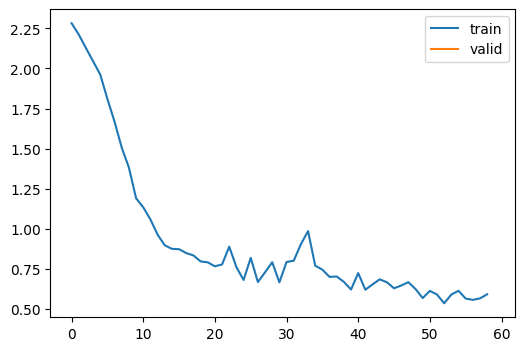

In [60]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
dls = prep_data()
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LR Finder

In [63]:
#| export
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): store_attr()
  
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

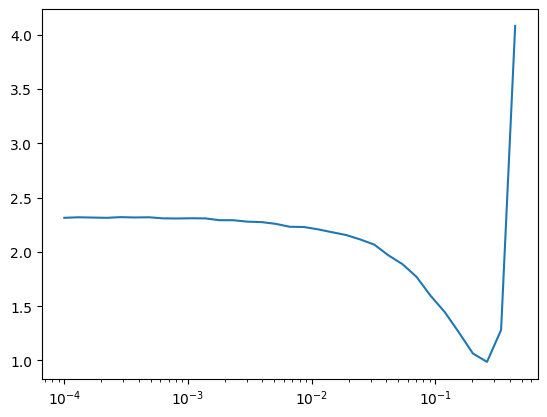

In [64]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log') 


> we can use pytorch learning rate scheduler to find the optimal learning rate

In [65]:
#| export
from torch.optim.lr_scheduler import ExponentialLR 

In [68]:
#| export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

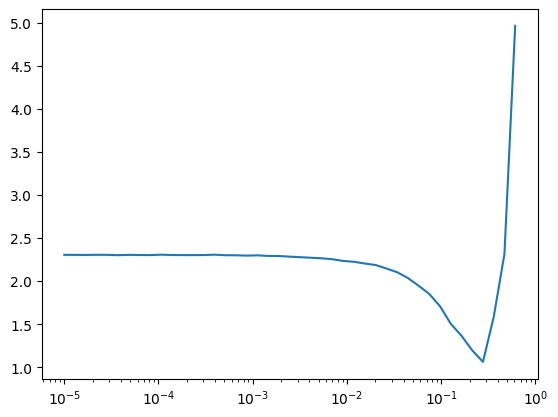

In [69]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

### shortcut for lr finder

In [73]:
#|export
@patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

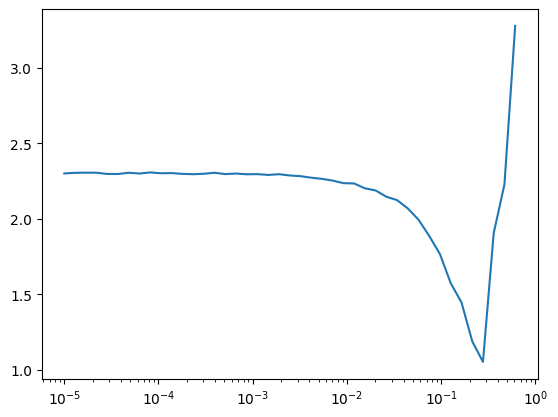

In [74]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

In [2]:
#| hide
import nbdev; nbdev.nbdev_export('03_preprocessing.lesson_16_after_lesson.ipynb')